In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from tensorflow import keras

In [2]:
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

Populating the interactive namespace from numpy and matplotlib


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Input, Dropout, BatchNormalization

In [137]:
from tensorflow.keras.utils import to_categorical

In [138]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [139]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler

In [140]:
from tensorflow.keras.models import load_model, Model

In [381]:
from tensorflow.keras import regularizers

In [141]:
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [143]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

(Class below comes from: https://stackoverflow.com/questions/67271590/issue-with-custom-metric-auc-callback-for-keras)

In [144]:
# Custom skelearn-based AUROC calculation class for use with the FULL validation 
#   set (not just mini-batches) at the end of each training epoch

class ROAUCMetrics(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.valid_x = val_data[0]
        self.valid_y = val_data[1]

    def on_train_begin(self, logs={}):
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.valid_x)
        val_auc = roc_auc_score(self.valid_y, pred,  average='micro')
        print('\nval-roc-auc: %s' % (str(round(val_auc,4))),end=100*' '+'\n\n')
        self.val_aucs.append(val_auc)
        return

# 1) Import the training data

In [145]:
X_train = np.load('data2/X_baby_train.dat')
y_train = np.load('data2/y_baby_train.dat')

X_val = np.load('data2/X_baby_val.dat')
y_val = np.load('data2/y_baby_val.dat')

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(985, 224, 273, 1)
(985, 4)
(247, 224, 273, 1)
(247, 4)


In [147]:
# Need these to be float32 format for custom loss function to work

y_train = y_train.astype(float)
y_val = y_val.astype(float) 

# 3) Let's Try a Pre-trained Model (VGG16) on just the first target (diagnosis = 'Atelectasis')

In [ ]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [91]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

### Standardize the X Data
(based on https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/)

In [92]:
batch_size = 32

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=31, val=8


In [93]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [94]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28673     
Total params: 14,743,391
Trainable params: 28,703
Non-trainable params: 14,714,688
_________________________________________________________________


In [95]:
initial_learning_rate = 0.0001
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [96]:
model.optimizer.get_config()['learning_rate']

0.0001

In [97]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_3.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0001
31/31 [==============================] - 250s 8s/step - loss: 0.6405 - val_loss: 0.6425

val-roc-auc: 0.5353                                                                                                    

Epoch 2/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 234s 8s/step - loss: 0.5970 - val_loss: 0.6230

val-roc-auc: 0.5777                                                                                                    

Epoch 3/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 230s 7s/step - loss: 0.5726 - val_loss: 0.6189

val-roc-auc: 0.5984                                                                                                    

Epoch 4/100
Learning Rate: 9.999999747378752e-05
31/31 [==============================] - 232s 8s/step - loss: 0.5622 - val_loss: 0.6205

val-roc-auc: 0.6108                                                                                 

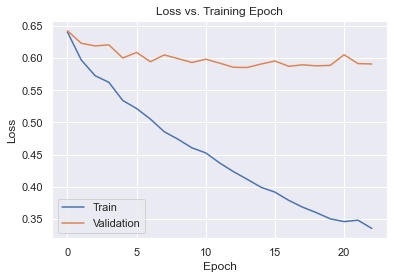

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [99]:
y_pred = model.predict(X_val)

In [100]:
roc_auc_score(y_val[:,target], y_pred)

0.6532797858099063

# 3b) Same as above (1st target only) but with a super simple output from VGG16

In [ ]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [190]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [191]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [192]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [193]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28673     
Total params: 14,743,391
Trainable params: 28,703
Non-trainable params: 14,714,688
_________________________________________________________________


In [194]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [195]:
model.optimizer.get_config()['learning_rate']

0.0005

In [196]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_3b.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 413s 117s/step - loss: 0.7404 - val_loss: 0.6574

val-roc-auc: 0.5001                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 438s 118s/step - loss: 0.6665 - val_loss: 0.6387

val-roc-auc: 0.5431                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 438s 113s/step - loss: 0.6328 - val_loss: 0.6404

val-roc-auc: 0.5652                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 444s 118s/step - loss: 0.5909 - val_loss: 0.6474

val-roc-auc: 0.5875                                                                                 

In [ ]:
# Best model saved is for epoch 48:  models_baby/model_3b.48-0.59.hdf5

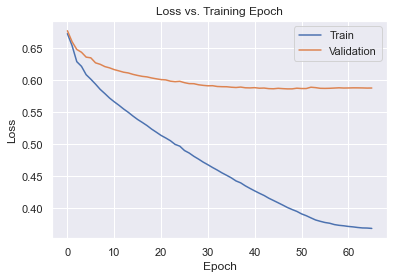

In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [197]:
y_pred = model.predict(X_val)

In [198]:
# Initial LR=0.0005, batch_size=256
roc_auc_score(y_val[:,target], y_pred)

0.6498958798155586

In [157]:
# Initial LR=0.0001, batch_size=256
roc_auc_score(y_val[:,target], y_pred)

0.6513461252417075

In [110]:
# Initial LR=0.0001, batch_size=32
roc_auc_score(y_val[:,target], y_pred)

0.6532797858099063

In [88]:
# Initial LR=0.001, batch_size=32
roc_auc_score(y_val[:,target], y_pred)

0.6481481481481483

# 4) Let's Try InceptionV3 Pre-Trained Model

In [ ]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [158]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [159]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [160]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import InceptionV3

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         pooling='avg',
                         input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

87916544/87910968 [==============================] - 32s 0us/step


In [161]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,863
Trainable params: 2,079
Non-trainable params: 21,802,784
_________________________________________________________________


In [162]:
initial_learning_rate = 0.0002
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [163]:
model.optimizer.get_config()['learning_rate']

0.0002

In [164]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_4.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0002
4/4 [==============================] - 148s 36s/step - loss: 0.6884 - val_loss: 0.6877

val-roc-auc: 0.4936                                                                                                    

Epoch 2/100
Learning Rate: 0.00019999999494757503
4/4 [==============================] - 132s 36s/step - loss: 0.6751 - val_loss: 0.6838

val-roc-auc: 0.4907                                                                                                    

Epoch 3/100
Learning Rate: 0.00019999999494757503
4/4 [==============================] - 135s 34s/step - loss: 0.6678 - val_loss: 0.6748

val-roc-auc: 0.4907                                                                                                    

Epoch 4/100
Learning Rate: 0.00019999999494757503
4/4 [==============================] - 132s 34s/step - loss: 0.6596 - val_loss: 0.6709

val-roc-auc: 0.4917                                                                                  

KeyboardInterrupt: 

# 5) Now (VGG16) w/ trainable layers 4 & 5 (just first target, 'Atelectasis') and drop Dense layers

In [ ]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [243]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [244]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [245]:
keras.backend.clear_session()

# dropout = 0.4

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

x = BatchNormalization(axis=1, trainable = None)(x)  # Helps with regularization

base_model = VGG16(weights='imagenet',
                         include_top=False,
                         pooling='avg',
                         input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if ('block5_' not in layer.name) and ('block4_' not in layer.name):
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer global_average_pooling2d frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0         
_______________________________________________________________

In [246]:
out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [247]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 273, 3)       896       
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,716,127
Trainable params: 12,979,743
Non-trainable params: 1,736,384
_______________________________________

In [248]:
initial_learning_rate = 0.00005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [249]:
model.optimizer.get_config()['learning_rate']

5e-05

In [250]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_5.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 5e-05


2022-01-18 20:40:51.027409: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_98 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_98 is not found


2022-01-18 20:40:51.027507: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_98 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_98 is not found


	 [[{{node PyFunc}}]]
2022-01-18 20:40:51.414074: W tensorflow/core/framework/op_kernel.cc:1755

4/4 [==============================] - 471s 125s/step - loss: 0.7077 - val_loss: 0.6277

val-roc-auc: 0.5543                                                                                                    

Epoch 2/100
Learning Rate: 4.999999873689376e-05
4/4 [==============================] - 472s 125s/step - loss: 0.6325 - val_loss: 0.6273

val-roc-auc: 0.5657                                                                                                    

Epoch 3/100
Learning Rate: 4.999999873689376e-05
4/4 [==============================] - 463s 117s/step - loss: 0.6261 - val_loss: 0.6291

val-roc-auc: 0.5813                                                                                                    

Epoch 4/100
Learning Rate: 4.999999873689376e-05
4/4 [==============================] - 465s 118s/step - loss: 0.6231 - val_loss: 0.6271

val-roc-auc: 0.5926                                                                                                    

Epoch 5/100
L

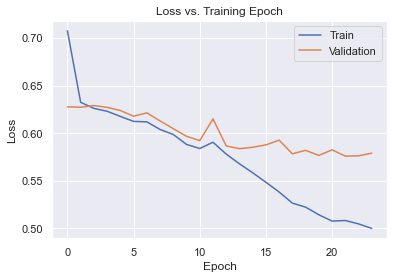

In [252]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [253]:
y_pred = model.predict(X_val)

In [256]:
# batch_size=256, initial_lr=0.00005

roc_auc_score(y_val[:,target], y_pred)

0.6553621894987356

# 7) Let's Try a Pre-trained Model (VGG16) on just the last target

In [288]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

In [289]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [290]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [291]:
keras.backend.clear_session()

dropout = 0.25

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu')(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [292]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [293]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [294]:
model.optimizer.get_config()['learning_rate']

0.0005

In [295]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_7.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 394s 105s/step - loss: 0.9315 - val_loss: 0.6313


2022-01-19 01:35:41.558594: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_110 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_110 is not found


2022-01-19 01:35:41.558686: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_110 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_110 is not found


	 [[{{node PyFunc}}]]



val-roc-auc: 0.5892                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 393s 105s/step - loss: 0.7473 - val_loss: 0.6188

val-roc-auc: 0.6739                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 396s 101s/step - loss: 0.6819 - val_loss: 0.5986

val-roc-auc: 0.6857                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 394s 100s/step - loss: 0.6088 - val_loss: 0.5813

val-roc-auc: 0.6959                                                                                                    

Epoch 5/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 395s 105s/ste

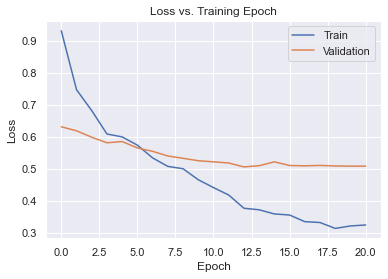

In [296]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [297]:
y_pred = model.predict(X_val)

In [298]:
# batch_size=256, initial_lr=0.0005

roc_auc_score(y_val[:,target], y_pred)

0.7482847341337908

# 8) Now (VGG16) w/ trainable layer_5 (just last target) and drop Dense layers

In [299]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

In [300]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [301]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [302]:
keras.backend.clear_session()

# dropout = 0.25

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [303]:
out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [304]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28673     
Total params: 14,743,391
Trainable params: 7,108,127
Non-trainable params: 7,635,264
_________________________________________________________________


In [305]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [306]:
model.optimizer.get_config()['learning_rate']

0.0005

In [307]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_8.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 415s 111s/step - loss: 1.0123 - val_loss: 0.6735

val-roc-auc: 0.5594                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 412s 111s/step - loss: 0.6639 - val_loss: 0.6644

val-roc-auc: 0.6334                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 428s 111s/step - loss: 0.6514 - val_loss: 0.6512

val-roc-auc: 0.6498                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 424s 109s/step - loss: 0.6425 - val_loss: 0.6268

val-roc-auc: 0.675                                                                                  

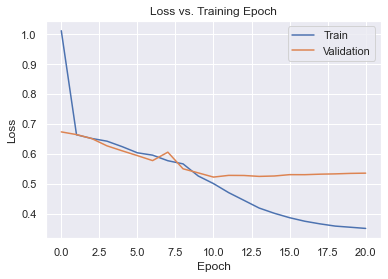

In [308]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [324]:
model = load_model('models_baby2/model_8.11-0.76.hdf5')

In [325]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [327]:
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))

Training AUC: 0.8098
Validation AUC: 0.7625


# 9) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5  (just last target)

In [311]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

In [312]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [313]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [314]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [315]:
dropout = 0.25

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu')(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [316]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [317]:
initial_learning_rate = 0.0001
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [318]:
model.optimizer.get_config()['learning_rate']

0.0001

In [319]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_9.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0001
4/4 [==============================] - 410s 109s/step - loss: 0.6757 - val_loss: 0.6441

val-roc-auc: 0.57                                                                                                    

Epoch 2/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 411s 110s/step - loss: 0.6433 - val_loss: 0.6039

val-roc-auc: 0.6747                                                                                                    

Epoch 3/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 413s 105s/step - loss: 0.5862 - val_loss: 0.5578

val-roc-auc: 0.7176                                                                                                    

Epoch 4/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 414s 105s/step - loss: 0.5374 - val_loss: 0.5592

val-roc-auc: 0.7492                                                                                   

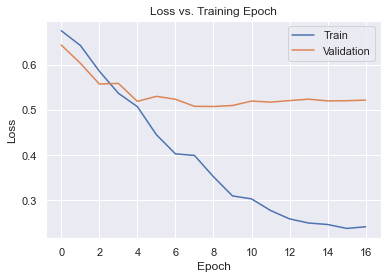

In [320]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [321]:
y_pred = model.predict(X_val)

In [322]:
roc_auc_score(y_val[:,target], y_pred)

0.7518582046883934

# 10) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (first target, 'Atelectasis')

In [404]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [406]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.52


In [407]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [408]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [409]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [410]:
dropout = 0.3
l1_reg = 0.00001
l2_reg = 0.0001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, 
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64,
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [411]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [412]:
initial_learning_rate = 0.00025
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [413]:
model.optimizer.get_config()['learning_rate']

0.00025

In [414]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 class_weight=class_weights, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_10.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.00025
4/4 [==============================] - 424s 112s/step - loss: 1.0712 - val_loss: 0.9954

val-roc-auc: 0.4904                                                                                                    

Epoch 2/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 426s 114s/step - loss: 0.9872 - val_loss: 0.9882

val-roc-auc: 0.6118                                                                                                    

Epoch 3/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 424s 107s/step - loss: 0.9579 - val_loss: 0.9148

val-roc-auc: 0.5834                                                                                                    

Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 420s 107s/step - loss: 0.9416 - val_loss: 0.9274

val-roc-auc: 0.6209                                                                                

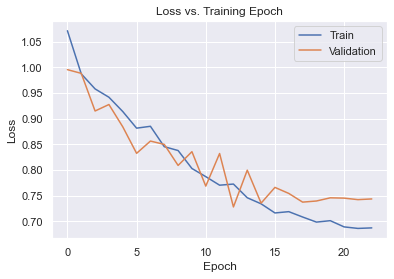

In [415]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [416]:
## BEST MODEL is Epoch 13: 'models_baby2/model_10.13-0.6911.hdf5'

y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [417]:
target

0

# ************ THIS ONE! ************

In [421]:
# dropout = 0.3
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (0):
Validation AUC: 0.6911
Training AUC: 0.7066


In [422]:
print('SECONDARY TARGET ({}):'.format(1))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,1], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,1], y_pred_train), 4)))

SECONDARY TARGET (1):
Validation AUC: 0.5596
Training AUC: 0.5619


In [423]:
print('SECONDARY TARGET ({}):'.format(2))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,2], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,2], y_pred_train), 4)))

SECONDARY TARGET (2):
Validation AUC: 0.6281
Training AUC: 0.6387


In [424]:
print('SECONDARY TARGET ({}):'.format(3))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,3], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,3], y_pred_train), 4)))

SECONDARY TARGET (3):
Validation AUC: 0.6885
Training AUC: 0.701


# 11) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer 5 (third target)

In [535]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 2

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [536]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.71
Weight for class 1: 1.68


In [537]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [538]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [539]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if ('block5_' not in layer.name):
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [540]:
dropout = 0.35
l1_reg = 0.00025
l2_reg = 0.0025

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, 
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64,
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [541]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [542]:
initial_learning_rate = 0.00025
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [543]:
model.optimizer.get_config()['learning_rate']

0.00025

In [544]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 class_weight=class_weights, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby2/model_11.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.00025
4/4 [==============================] - 435s 116s/step - loss: 8.0826 - val_loss: 7.5679

val-roc-auc: 0.5573                                                                                                    

Epoch 2/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 434s 116s/step - loss: 7.2886 - val_loss: 6.8010

val-roc-auc: 0.5757                                                                                                    

Epoch 3/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 420s 106s/step - loss: 6.5214 - val_loss: 6.0155

val-roc-auc: 0.6456                                                                                                    

Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 424s 107s/step - loss: 5.7786 - val_loss: 5.5205

val-roc-auc: 0.7043                                                                                

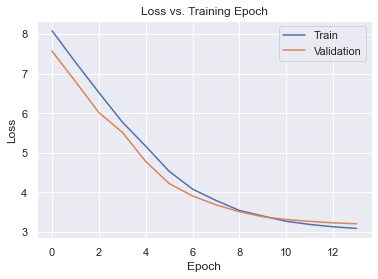

In [545]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [546]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [547]:
target

2

In [548]:
# dropout = 0.35
# l1_reg = 0.00025
# l2_reg = 0.0025

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (2):
Validation AUC: 0.7043
Training AUC: 0.7376


In [534]:
# dropout = 0.4
# l1_reg = 0.0001
# l2_reg = 0.001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (2):
Validation AUC: 0.6728
Training AUC: 0.8952


In [521]:
# dropout = 0.3
# l1_reg = 0.0001
# l2_reg = 0.001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (2):
Validation AUC: 0.6697
Training AUC: 0.8672


In [472]:
# dropout = 0.35
# l1_reg = 0.00005
# l2_reg = 0.0005

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (2):
Validation AUC: 0.6336
Training AUC: 0.8532


In [459]:
# dropout = 0.35
# l1_reg = 0.0001
# l2_reg = 0.001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (2):
Validation AUC: 0.696
Training AUC: 0.7849
